In [1]:
import gym
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow import keras
from ns3gym import ns3env

/home/sheila/anaconda3/envs/environment_py3_7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sheila/anaconda3/envs/environment_py3_7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sheila/anaconda3/envs/environment_py3_7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sheila/

In [2]:
seed = 42
np.random.seed(seed)
tf.random.set_random_seed(seed)#tf.random.set_seed(seed)
random.seed(seed)

In [3]:
#  collisionTh = 7
#  collisions = 19

env = gym.make('ns3-v0') # environment ID

# numero de estados
s_num = env.observation_space.shape[0]

# numero de acoes
a_num = env.action_space.n

print("\n")
print("Numero de Estados: ", s_num)
print("Numero de Acoes: ", a_num) 

"""
# ambiente anterior
Q = np.array(np.zeros([4,4]))
"""

# ambiente atual
Q_table = np.zeros([s_num, a_num])

Got new port for ns3gm interface:  5913


Numero de Estados:  4
Numero de Acoes:  4


In [4]:
"""
def choose_action(s, s_num, epsilon):
# Selecione a ação com o maior valor Q.
    if np.random.uniform() < epsilon:
        a = int(np.max(Q_table[np.argwhere(s)[0][0]]))
# Selecione uma ação aleatóriamente.
    else:
        a = np.random.randint(0, s_num)
    return a
"""
def choose_action(s, s_num, epsilon):
# Selecione a ação com o maior valor Q.
    if np.random.uniform() >= epsilon:
        a = int(np.max(Q_table[np.argwhere(s)[0][0]]))
# Selecione uma ação aleatóriamente.
    else:
        a = np.random.randint(0, s_num)
    return a




In [5]:
numOfEpisodes = 100
numTimeSlots = 200

discount_rate = 0.628 # gamma 0.95; 0.93
# learning rate
#learning_rate0 = 0.05 # 0.05 # alpha; 0.4
#learning_rate_decay = 0.1 # 0.1 alpha_decay
learning_rate = 0.7

# exploration rate
#epsilon = 0.4               
# epsilon_min = 0.01
# epsilon_decay = 0.999
#epsilon = 1.0               # exploration rate
#epsilon_min = 0.01
#epsilon_decay = 0.999

epsilon = 1.0 # Epsilon-greedy algorithm in initialized at 1 meaning every step is random at the start
max_epsilon = 1.0 # You can't explore more than 100% of the time
min_epsilon = 1e-10 # 0.0000001 # At a minimum, we'll always explore 1% of the time
decay = 1e-10 # 0.0000001





episode_reward = np.zeros((numOfEpisodes,))
max_reward =  np.zeros((numOfEpisodes,))



for episode in range(numOfEpisodes):
    
    print('Episode:', episode)
    collisionCnt = 0    
    
    # s - Current State
    s = env.reset()
    s = np.reshape(s, [1, s_num])    

    
    for iteration in range(numTimeSlots):
        
        # a - Action   
        a = choose_action(s, s_num, epsilon) # acao    
    
        # Step
        next_state, reward, done, _, _ = env.step(a) # toma uma ação  no ambiente a cada passo de tempo
               
        
        next_state = np.array(next_state)
        
        # Accumulate reward.
        episode_reward[episode] += reward  
        
                
        if reward == -1.0:
            collisionCnt += 1          
                        
    
    
        # state index
        s_index   = np.argwhere(s==1)[0][0] 
        
        # next-state index
        n_s_index   = np.argwhere(next_state==1)[0][0]            
        
        
        # next-state Q-valor Maximo
        n_s_Qmax = np.max(Q_table[n_s_index])
    
       
        print("Time Slot    :", iteration)
        print("----------------------", "\n")
        print("Current State:", s, "-->", s_index)
        print("Action       :", a)
        print("Next state   :", next_state, "-->", n_s_index) #, "-->", (s + 1) % 4
        print("Reward       :", reward)
        print("CollisionCnt :", collisionCnt)
        print("Gameover     :", done)
        print("----------------------", "\n")  
    
    
        #learning_rate = learning_rate0 / (1 + iteration * learning_rate_decay)# passo de aprendizagem
    
        # Calculates and updates the Q-table values
        Q_table[s_index, a] = (1 - learning_rate) * Q_table[s_index, a] + learning_rate * (
        reward + discount_rate * n_s_Qmax)
        
          
        
        print("Tabela do Q-value Maximo")
        print(Q_table, "\n")
        print("Acao otima para cada canal:", np.argmax(Q_table, axis=1), "\n")
        print("---------------------------", "\n")
        
        if done == True:
            print('########## Game Over ##########', collisionCnt)
            break
                   
        
        # updates the current state
        s = next_state
                
        # updates the exploration rate
        #if epsilon > epsilon_min: epsilon *= epsilon_decay
            
    # Store maxmim possible reward per episode.
    max_reward[episode] = iteration + 1
    
    #Decrease epsilon along the way.
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)

Episode: 0
0,0,0,0,0,0,0,0,0,1
Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 2
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[0.  0.  0.7 0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]] 

Acao otima para cada canal: [2 0 0 0] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 0
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[0.  0.  0.7 0. ]
 [0.7 0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]] 

Acao otima para cada canal: [2 0 0 0] 

--------------------------- 

Time Slot    : 2
---------------------- 

Current State: [0 0 1 0] --> 2
Action       : 1
Next state   : [0 0 0 1] --> 3
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do 

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 3
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[ 1.62323343  1.63371261  1.35299371  2.21962171]
 [ 1.92636834  1.94176921 -0.07908257  1.95890669]
 [ 2.02918445  1.82581967  2.17604798  0.17073362]
 [ 0.26490196  1.29477604  2.0451553   2.2435995 ]] 

Acao otima para cada canal: [3 3 2 3] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 0
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[ 1.62323343  1.63371261  1.35299371  2.21962171]
 [ 2.23450119  1.94176921 -0.07908257  1.95890669]
 [ 2.02918445  1.82581967  2.17604798  0.17073362]
 [ 0.26490196  1.29477604  2.0451553   2.2435995 ]] 

Acao otima para cada canal: [3 0 2 3] 

------------------

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 3
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.49150675 0.82237074 2.13117844 2.5379249 ]
 [2.42012244 2.44946293 0.50684581 2.31594069]
 [2.46722848 2.30513196 2.52281988 0.40860615]
 [0.43882184 2.15464001 2.51791128 2.51686741]] 

Acao otima para cada canal: [3 1 2 2] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 0
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.49150675 0.82237074 2.13117844 2.5379249 ]
 [2.53506835 2.44946293 0.50684581 2.31594069]
 [2.46722848 2.30513196 2.52281988 0.40860615]
 [0.43882184 2.15464001 2.51791128 2.51686741]] 

Acao otima para cada canal: [3 0 2 2] 

--------------------------- 

Time Slot    : 2
---

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 1
Next state   : [0 1 0 0] --> 1
Reward       : -1.0
CollisionCnt : 1
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.61225112 0.70380715 2.58631296 2.60341457]
 [2.63215635 2.5720576  0.57173356 2.31594069]
 [2.6016622  2.61804592 2.58693976 0.57914023]
 [0.57999215 2.15464001 2.63093354 2.6195652 ]] 

Acao otima para cada canal: [0 0 1 2] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 3
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 1
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.61225112 0.70380715 2.58631296 2.60341457]
 [2.63215635 2.5720576  0.57173356 2.5456752 ]
 [2.6016622  2.61804592 2.58693976 0.57914023]
 [0.57999215 2.15464001 2.63093354 2.6195652 ]] 

Acao otima para cada canal: [0 0 1 2] 

--------------------------- 

Time Slot    : 2
--

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 0
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.66315414 0.70380715 2.65435215 2.66641942]
 [2.6585873  2.5720576  0.66047253 2.63411223]
 [2.6476755  2.61804592 2.66244238 0.6422793 ]
 [0.66745727 2.62210891 2.65818297 2.6195652 ]] 

Acao otima para cada canal: [3 0 2 2] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 2
Next state   : [0 0 1 0] --> 2
Reward       : -1.0
CollisionCnt : 1
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.66315414 0.70380715 2.65435215 2.66641942]
 [2.6585873  2.5720576  0.66855143 2.63411223]
 [2.6476755  2.61804592 2.66244238 0.6422793 ]
 [0.66745727 2.62210891 2.65818297 2.6195652 ]] 

Acao otima para cada canal: [3 0 2 2] 

--------------------------- 

Time Slot    : 2
--

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 3
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.66864187 1.10056339 2.67301798 2.67735515]
 [2.6585873  2.64220169 0.67114984 2.67577068]
 [2.67316135 2.67375471 2.66244238 0.6743057 ]
 [0.66745727 2.66169138 2.67645274 2.67502138]] 

Acao otima para cada canal: [3 3 1 2] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 3
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.66864187 1.10056339 2.67301798 2.67735515]
 [2.6585873  2.64220169 0.67114984 2.67811377]
 [2.67316135 2.67375471 2.66244238 0.6743057 ]
 [0.66745727 2.66169138 2.67645274 2.67502138]] 

Acao otima para cada canal: [3 3 1 2] 

--------------------------- 

Time Slot    : 2
---

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 3
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.26316055 0.80771516 2.67301798 2.68169775]
 [2.6585873  2.67867639 0.67114984 2.67811377]
 [2.67984418 2.67375471 2.68117671 0.68159033]
 [0.66745727 2.67685757 2.67645274 2.68266293]] 

Acao otima para cada canal: [3 1 2 3] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 2
Next state   : [0 0 1 0] --> 2
Reward       : -1.0
CollisionCnt : 1
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.26316055 0.80771516 2.67301798 2.68169775]
 [2.6585873  2.67867639 0.67999024 2.67811377]
 [2.67984418 2.67375471 2.68117671 0.68159033]
 [0.66745727 2.67685757 2.67645274 2.68266293]] 

Acao otima para cada canal: [3 1 2 3] 

--------------------------- 

Time Slot    : 2
--

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 2
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[1.24582262 0.72140465 2.68292556 2.68359942]
 [2.67633064 2.67867639 0.68391592 2.68218858]
 [2.67984418 2.68407381 2.68117671 0.68487546]
 [0.66745727 2.68345381 2.67645274 2.68481227]] 

Acao otima para cada canal: [3 3 1 3] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 1
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[1.24582262 0.72140465 2.68292556 2.68359942]
 [2.67633064 2.68352176 0.68391592 2.68218858]
 [2.67984418 2.68407381 2.68117671 0.68487546]
 [0.66745727 2.68345381 2.67645274 2.68481227]] 

Acao otima para cada canal: [3 1 1 3] 

--------------------------- 

Time Slot    : 2
---

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 1
Next state   : [0 1 0 0] --> 1
Reward       : -1.0
CollisionCnt : 1
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[0.85396552 0.81291625 2.68528599 2.68475599]
 [2.68342988 2.68578752 0.68391592 2.68518726]
 [2.68592128 2.68546562 2.68608628 0.68487546]
 [0.66745727 2.68474645 2.68315456 2.6861812 ]] 

Acao otima para cada canal: [2 1 2 3] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 1
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 1
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[0.85396552 0.81291625 2.68528599 2.68475599]
 [2.68342988 2.68653978 0.68391592 2.68518726]
 [2.68592128 2.68546562 2.68608628 0.68487546]
 [0.66745727 2.68474645 2.68315456 2.6861812 ]] 

Acao otima para cada canal: [2 1 2 3] 

--------------------------- 

Time Slot    : 2
--

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 1
Next state   : [0 1 0 0] --> 1
Reward       : -1.0
CollisionCnt : 1
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[1.12218485 0.69886804 2.68528599 2.68642969]
 [2.68342988 2.68738614 0.68391592 2.68518726]
 [2.68689756 2.68546562 2.68712251 0.68630789]
 [0.68516116 2.68637843 2.68315456 2.68680885]] 

Acao otima para cada canal: [3 1 2 3] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 1
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 1
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[1.12218485 0.69886804 2.68528599 2.68642969]
 [2.68342988 2.6874749  0.68391592 2.68518726]
 [2.68689756 2.68546562 2.68712251 0.68630789]
 [0.68516116 2.68637843 2.68315456 2.68680885]] 

Acao otima para cada canal: [3 1 2 3] 

--------------------------- 

Time Slot    : 2
--

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 2
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.21806942 0.68873628 2.68751389 2.68734287]
 [2.68628802 2.6874749  0.6864571  2.68730363]
 [2.68689756 2.68717544 2.68728393 0.68725905]
 [0.68758409 2.68686802 2.68315456 2.68739858]] 

Acao otima para cada canal: [2 1 2 3] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 3
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.21806942 0.68873628 2.68751389 2.68734287]
 [2.68628802 2.6874749  0.6864571  2.68752111]
 [2.68689756 2.68717544 2.68728393 0.68725905]
 [0.68758409 2.68686802 2.68315456 2.68739858]] 

Acao otima para cada canal: [2 3 2 3] 

--------------------------- 

Time Slot    : 2
---

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 2
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.67519723 0.68873628 2.68788919 2.68785853]
 [2.68770033 2.687682   0.6864571  2.68785864]
 [2.68772614 2.68753305 2.68788314 0.68779193]
 [0.68795673 2.68785308 2.68315456 2.68765068]] 

Acao otima para cada canal: [2 3 2 1] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 1
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.67519723 0.68873628 2.68788919 2.68785853]
 [2.68770033 2.68789803 0.6864571  2.68785864]
 [2.68772614 2.68753305 2.68788314 0.68779193]
 [0.68795673 2.68785308 2.68315456 2.68765068]] 

Acao otima para cada canal: [2 1 2 1] 

--------------------------- 

Time Slot    : 2
---

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 1
Next state   : [0 1 0 0] --> 1
Reward       : -1.0
CollisionCnt : 1
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[1.28684383 0.68812095 2.68788919 2.68804196]
 [2.68800307 2.68796284 0.68758792 2.68785864]
 [2.68801363 2.68784013 2.68788314 0.68796128]
 [0.68803359 2.68795201 2.68315456 2.68789129]] 

Acao otima para cada canal: [3 0 0 1] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 2
Next state   : [0 0 1 0] --> 2
Reward       : -1.0
CollisionCnt : 2
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[1.28684383 0.68812095 2.68788919 2.68804196]
 [2.68800307 2.68796284 0.68792717 2.68785864]
 [2.68801363 2.68784013 2.68788314 0.68796128]
 [0.68803359 2.68795201 2.68315456 2.68789129]] 

Acao otima para cada canal: [3 0 0 1] 

--------------------------- 

Time Slot    : 2
-

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 2
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[0.86773977 0.68812095 2.26812231 2.68809513]
 [2.68809904 2.68796284 0.68803517 2.68785864]
 [2.68809526 2.68807261 2.68802321 0.68796128]
 [0.6880807  2.68805622 2.68663298 2.68809581]] 

Acao otima para cada canal: [3 0 0 3] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 3
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[0.86773977 0.68812095 2.26812231 2.68809513]
 [2.68809904 2.68796284 0.68803517 2.68804427]
 [2.68809526 2.68807261 2.68802321 0.68796128]
 [0.6880807  2.68805622 2.68663298 2.68809581]] 

Acao otima para cada canal: [3 0 0 3] 

--------------------------- 

Time Slot    : 2
---

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 2
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.14201817 1.10813791 2.56213325 2.68813124]
 [2.68809904 2.68811701 0.68803517 2.68811772]
 [2.68812667 2.68813568 2.6881143  0.6880839 ]
 [0.6880807  2.68805622 2.68769239 2.68814226]] 

Acao otima para cada canal: [3 3 1 3] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 0
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.14201817 1.10813791 2.56213325 2.68813124]
 [2.68813416 2.68811701 0.68803517 2.68811772]
 [2.68812667 2.68813568 2.6881143  0.6880839 ]
 [0.6880807  2.68805622 2.68769239 2.68814226]] 

Acao otima para cada canal: [3 0 1 3] 

--------------------------- 

Time Slot    : 2
---

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 0
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68683561 1.14595903 2.65034247 2.68813124]
 [2.68813416 2.68815862 0.68814766 2.68811772]
 [2.68815262 2.68814804 2.68814163 0.68813251]
 [0.6881405  2.68814398 2.68801021 2.68814226]] 

Acao otima para cada canal: [3 1 0 1] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 1
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68683561 1.14595903 2.65034247 2.68813124]
 [2.68813416 2.68815948 0.68814766 2.68811772]
 [2.68815262 2.68814804 2.68814163 0.68813251]
 [0.6881405  2.68814398 2.68801021 2.68814226]] 

Acao otima para cada canal: [3 1 0 1] 

--------------------------- 

Time Slot    : 2
---

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 0
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68812856 1.11187084 2.67681776 2.68815899]
 [2.68813416 2.68815973 0.68815725 2.68816002]
 [2.68815544 2.68815503 2.68815514 0.68813251]
 [0.68814589 2.68814398 2.68814434 2.6881585 ]] 

Acao otima para cada canal: [3 3 0 3] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 1
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68812856 1.11187084 2.67681776 2.68815899]
 [2.68813416 2.68816105 0.68815725 2.68816002]
 [2.68815544 2.68815503 2.68815514 0.68813251]
 [0.68814589 2.68814398 2.68814434 2.6881585 ]] 

Acao otima para cada canal: [3 1 0 3] 

--------------------------- 

Time Slot    : 2
---

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 2
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[1.28815515 0.7263003  2.68807584 2.68816653]
 [2.68816238 2.68816536 0.68815725 2.68816002]
 [2.68816547 2.68816561 2.68816102 0.6881627 ]
 [0.68816724 2.68815978 2.68816455 2.6881585 ]] 

Acao otima para cada canal: [3 1 1 2] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 2
Next state   : [0 0 1 0] --> 2
Reward       : -1.0
CollisionCnt : 1
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[1.28815515 0.7263003  2.68807584 2.68816653]
 [2.68816238 2.68816536 0.68816478 2.68816002]
 [2.68816547 2.68816561 2.68816102 0.6881627 ]
 [0.68816724 2.68815978 2.68816455 2.6881585 ]] 

Acao otima para cada canal: [3 1 1 2] 

--------------------------- 

Time Slot    : 2
--

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 1
Next state   : [0 1 0 0] --> 1
Reward       : -1.0
CollisionCnt : 1
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.6503702  0.8142635  2.68816819 2.68816934]
 [2.6881703  2.68816997 0.68816919 2.68816989]
 [2.6881695  2.68817052 2.68817021 0.68816656]
 [0.68816724 2.68816985 2.68817024 2.68816992]] 

Acao otima para cada canal: [3 0 1 2] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 2
Next state   : [0 0 1 0] --> 2
Reward       : -1.0
CollisionCnt : 2
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.6503702  0.8142635  2.68816819 2.68816934]
 [2.6881703  2.68816997 0.68817052 2.68816989]
 [2.6881695  2.68817052 2.68817021 0.68816656]
 [0.68816724 2.68816985 2.68817024 2.68816992]] 

Acao otima para cada canal: [3 0 1 2] 

--------------------------- 

Time Slot    : 2
-

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 2
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.67683091 0.7259989  2.68817111 2.688171  ]
 [2.68817102 2.68817075 0.68817052 2.68817098]
 [2.6881695  2.68817052 2.68817111 0.68817079]
 [0.68817126 2.68817069 2.68817024 2.68816992]] 

Acao otima para cada canal: [2 0 2 1] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 1
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.67683091 0.7259989  2.68817111 2.688171  ]
 [2.68817102 2.68817124 0.68817052 2.68817098]
 [2.6881695  2.68817052 2.68817111 0.68817079]
 [0.68817126 2.68817069 2.68817024 2.68816992]] 

Acao otima para cada canal: [2 1 2 1] 

--------------------------- 

Time Slot    : 2
---

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 3
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68786548 0.69157617 2.68817141 2.68817152]
 [2.68817102 2.68817124 0.68817127 2.68817157]
 [2.6881695  2.68817052 2.68817161 0.68817163]
 [0.68817153 2.68817156 2.68817122 2.68817099]] 

Acao otima para cada canal: [3 3 2 1] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 1
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68786548 0.69157617 2.68817141 2.68817152]
 [2.68817102 2.68817161 0.68817127 2.68817157]
 [2.6881695  2.68817052 2.68817161 0.68817163]
 [0.68817153 2.68817156 2.68817122 2.68817099]] 

Acao otima para cada canal: [3 1 2 1] 

--------------------------- 

Time Slot    : 2
---

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 3
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.2681443  2.0891931  2.68817181 2.68817178]
 [2.68817155 2.6881718  0.6881717  2.68817172]
 [2.68817114 2.6881718  2.68817185 0.68817163]
 [0.68817179 2.6881718  2.68817173 2.68817178]] 

Acao otima para cada canal: [2 1 2 1] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 1
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.2681443  2.0891931  2.68817181 2.68817178]
 [2.68817155 2.68817189 0.6881717  2.68817172]
 [2.68817114 2.6881718  2.68817185 0.68817163]
 [0.68817179 2.6881718  2.68817173 2.68817178]] 

Acao otima para cada canal: [2 1 2 1] 

--------------------------- 

Time Slot    : 2
---

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 3
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.2681443  0.81426387 2.68817193 2.68817195]
 [2.68817182 2.68817189 0.68817187 2.68817193]
 [2.68817186 2.68817189 2.68817188 0.68817186]
 [0.68817195 2.68817187 2.68817185 2.68817191]] 

Acao otima para cada canal: [3 3 1 3] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 3
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.2681443  0.81426387 2.68817193 2.68817195]
 [2.68817182 2.68817189 0.68817187 2.68817194]
 [2.68817186 2.68817189 2.68817188 0.68817186]
 [0.68817195 2.68817187 2.68817185 2.68817191]] 

Acao otima para cada canal: [3 3 1 3] 

--------------------------- 

Time Slot    : 2
---

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 3
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.5621637  0.72599955 2.68817199 2.68817201]
 [2.688172   2.688172   0.688172   2.68817194]
 [2.688172   2.68817199 2.68817198 0.688172  ]
 [0.68817199 2.68817195 2.68817202 2.688172  ]] 

Acao otima para cada canal: [3 0 0 2] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 1
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.5621637  0.72599955 2.68817199 2.68817201]
 [2.688172   2.68817201 0.688172   2.68817194]
 [2.688172   2.68817199 2.68817198 0.688172  ]
 [0.68817199 2.68817195 2.68817202 2.688172  ]] 

Acao otima para cada canal: [3 1 0 2] 

--------------------------- 

Time Slot    : 2
---

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 0
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.65036954 2.08919337 2.68817203 2.68817202]
 [2.688172   2.68817203 0.68817202 2.688172  ]
 [2.68817203 2.68817203 2.68817201 0.68817202]
 [0.68817203 2.68817201 2.68817203 2.68817202]] 

Acao otima para cada canal: [2 1 0 2] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 1
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.65036954 2.08919337 2.68817203 2.68817202]
 [2.688172   2.68817203 0.68817202 2.688172  ]
 [2.68817203 2.68817203 2.68817201 0.68817202]
 [0.68817203 2.68817201 2.68817203 2.68817202]] 

Acao otima para cada canal: [2 1 0 2] 

--------------------------- 

Time Slot    : 2
---

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 1
Next state   : [0 1 0 0] --> 1
Reward       : -1.0
CollisionCnt : 1
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[1.28476981 1.10847844 2.68817203 2.68817204]
 [2.688172   2.68817203 0.68817203 2.68817203]
 [2.68817204 2.68817203 2.68817201 0.68817202]
 [0.68817203 2.68817201 2.68817203 2.68817204]] 

Acao otima para cada canal: [3 1 0 3] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 3
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 1
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[1.28476981 1.10847844 2.68817203 2.68817204]
 [2.688172   2.68817203 0.68817203 2.68817204]
 [2.68817204 2.68817203 2.68817201 0.68817202]
 [0.68817203 2.68817201 2.68817203 2.68817204]] 

Acao otima para cada canal: [3 3 0 3] 

--------------------------- 

Time Slot    : 2
--

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 1
Next state   : [0 1 0 0] --> 1
Reward       : -1.0
CollisionCnt : 1
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.56186584 0.72599962 2.68817203 2.68817204]
 [2.68817203 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817203 0.68817203]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 3 0 1] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 3
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 1
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.56186584 0.72599962 2.68817203 2.68817204]
 [2.68817203 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817203 0.68817203]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 3 0 1] 

--------------------------- 

Time Slot    : 2
--

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 3
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68476177 0.69157652 2.68817204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817203]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 1 1 2] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 0
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68476177 0.69157652 2.68817204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817203]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 1 1 2] 

--------------------------- 

Time Slot    : 2
---

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 0
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68807997 0.68919339 2.68817204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [2 0 0 3] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 0
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68807997 0.68919339 2.68817204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [2 0 0 3] 

--------------------------- 

Time Slot    : 2
---

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 0
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.2681713  0.68919339 2.68817204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 1 0 2] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 0
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.2681713  0.68919339 2.68817204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 1 0 2] 

--------------------------- 

Time Slot    : 2
---

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 1
Next state   : [0 1 0 0] --> 1
Reward       : -1.0
CollisionCnt : 1
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.2681713  0.68819962 1.28817204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 0 3] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 2
Next state   : [0 0 1 0] --> 2
Reward       : -1.0
CollisionCnt : 2
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.2681713  0.68819962 1.28817204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 0 3] 

--------------------------- 

Time Slot    : 2
-

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 3
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.56217182 0.68818032 2.56217204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 1 1 3] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 0
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.56217182 0.68818032 2.56217204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 1 3] 

--------------------------- 

Time Slot    : 2
---

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 3
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.56217182 1.10817279 2.67683204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 0 2] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 0
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.56217182 1.10817279 2.67683204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 0 2] 

--------------------------- 

Time Slot    : 2
---

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 1
Next state   : [0 1 0 0] --> 1
Reward       : -1.0
CollisionCnt : 1
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[1.28477004 0.72597211 2.67683204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 2 3] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 0
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 1
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[1.28477004 0.72597211 2.67683204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 2 3] 

--------------------------- 

Time Slot    : 2
--

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 0
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.26476178 0.69157405 2.67683204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 1 1 1] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 2
Next state   : [0 0 1 0] --> 2
Reward       : -1.0
CollisionCnt : 1
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.26476178 0.69157405 2.67683204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 1 1 1] 

--------------------------- 

Time Slot    : 2
--

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 0
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.67673997 0.68847822 2.67683204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 2 1] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 2
Next state   : [0 0 1 0] --> 2
Reward       : -1.0
CollisionCnt : 1
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.67673997 0.68847822 2.67683204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 2 1] 

--------------------------- 

Time Slot    : 2
--

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 1
Next state   : [0 1 0 0] --> 1
Reward       : -1.0
CollisionCnt : 1
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68474242 0.68818031 1.28477004 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 2 2] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 2
Next state   : [0 0 1 0] --> 2
Reward       : -1.0
CollisionCnt : 2
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68474242 0.68818031 1.28477004 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 2 2] 

--------------------------- 

Time Slot    : 2
-

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 2
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68714316 2.08817452 2.26715144 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 2 2] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 0
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68714316 2.08817452 2.26715144 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 2 2] 

--------------------------- 

Time Slot    : 2
---

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 0
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68786338 0.72597211 2.65028019 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 2 3] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 3
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68786338 0.72597211 2.65028019 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 2 3] 

--------------------------- 

Time Slot    : 2
---

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 0
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68816371 0.72597211 2.68476178 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 0 3] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 1
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68816371 0.72597211 2.68476178 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 0 3] 

--------------------------- 

Time Slot    : 2
---

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 1
Next state   : [0 1 0 0] --> 1
Reward       : -1.0
CollisionCnt : 1
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.26817182 0.68847822 2.68476178 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 2 1] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 2
Next state   : [0 0 1 0] --> 2
Reward       : -1.0
CollisionCnt : 2
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.26817182 0.68847822 2.68476178 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 2 1] 

--------------------------- 

Time Slot    : 2
-

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 2
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.56217198 2.0881996  2.68807997 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 1 2 1] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 1
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.56217198 2.0881996  2.68807997 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 1 2 1] 

--------------------------- 

Time Slot    : 2
---

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 3
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68477004 2.12597279 2.68816376 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 1 2] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 1
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68477004 2.12597279 2.68816376 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 1 2] 

--------------------------- 

Time Slot    : 2
---

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 1
Next state   : [0 1 0 0] --> 1
Reward       : -1.0
CollisionCnt : 1
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68808019 1.14699266 2.6881713  2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 1 1] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 1
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 1
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68808019 1.14699266 2.6881713  2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 1 1 1] 

--------------------------- 

Time Slot    : 2
--

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 1
Next state   : [0 1 0 0] --> 1
Reward       : -1.0
CollisionCnt : 1
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68814449 0.7005602  2.6881713  2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 2 1] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 0
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 1
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68814449 0.7005602  2.6881713  2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 2 1] 

--------------------------- 

Time Slot    : 2
--

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 3
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68816378 0.68928698 2.6881713  2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 0 1] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 1
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68816378 0.68928698 2.6881713  2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 1 0 1] 

--------------------------- 

Time Slot    : 2
---

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 2
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[1.28816956 0.68850652 2.68817204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 1 1] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 2
Next state   : [0 0 1 0] --> 2
Reward       : -1.0
CollisionCnt : 1
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[1.28816956 0.68850652 2.68817204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 1 1] 

--------------------------- 

Time Slot    : 2
--

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 0
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.56217182 2.08827239 2.68817204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 3 1 1] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 0
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.56217182 2.08827239 2.68817204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 1 1] 

--------------------------- 

Time Slot    : 2
---

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 2
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.67683202 2.21418107 2.68817204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 1 1] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 3
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.67683202 2.21418107 2.68817204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 1 1] 

--------------------------- 

Time Slot    : 2
---

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 0
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68808019 2.22551286 2.68817204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 0 1] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 3
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68808019 2.22551286 2.68817204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 0 1] 

--------------------------- 

Time Slot    : 2
---

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 2
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68816378 1.14937429 2.68817204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 0 1] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 0
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68816378 1.14937429 2.68817204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 0 1] 

--------------------------- 

Time Slot    : 2
---

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 2
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68816956 1.1206245  2.68817204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 0 1] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 2
Next state   : [0 0 1 0] --> 2
Reward       : -1.0
CollisionCnt : 1
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.68816956 1.1206245  2.68817204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 0 1] 

--------------------------- 

Time Slot    : 2
--

Time Slot    : 0
---------------------- 

Current State: [[1 0 0 0]] --> 0
Action       : 3
Next state   : [0 1 0 0] --> 1
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.6881713  1.1206245  2.68817204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 0 1] 

--------------------------- 

Time Slot    : 1
---------------------- 

Current State: [0 1 0 0] --> 1
Action       : 1
Next state   : [0 0 1 0] --> 2
Reward       : 1.0
CollisionCnt : 0
Gameover     : False
---------------------- 

Tabela do Q-value Maximo
[[2.6881713  1.1206245  2.68817204 2.68817204]
 [2.68817204 2.68817204 0.68817204 2.68817204]
 [2.68817204 2.68817204 2.68817204 0.68817204]
 [0.68817204 2.68817204 2.68817204 2.68817204]] 

Acao otima para cada canal: [3 0 0 1] 

--------------------------- 

Time Slot    : 2
---

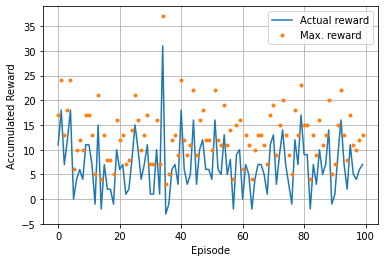

In [6]:
plt.plot(episode_reward, label='Actual reward')
plt.plot(max_reward, '.', label='Max. reward')
plt.xlabel('Episode')
plt.ylabel('Accumulated Reward')
plt.grid()
plt.legend()
plt.show()